In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from ta import add_all_ta_features

#Statistics
from statsmodels.tsa.stattools import adfuller

#Unsupervised ML
from sklearn.decomposition import PCA

#Supervised ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

#Reporting
import matplotlib.pyplot as plt

### Initial Data Extraction

In [2]:
#Data Extraction
start_date = '2017-01-01'
end_date = '2022-06-01'
symbol = '^VIX'


In [3]:
yf.pdr_override()


In [4]:
data = pdr.get_data_yahoo(symbol, start = start_date,end = end_date)


[*********************100%%**********************]  1 of 1 completed


In [5]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
#Add TA
df = add_all_ta_features(data, open = 'Open', high = 'High',low = 'Low', close = 'Adj Close', volume = 'Volume',fillna = True)

In [7]:
df.head(7)

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0,-0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.850000,0.000000,0.000000,0.000000
2017-01-04,12.78,12.80,11.63,11.85,11.85,0,-0.0,0,0.0,-0.0,...,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,12.098375,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,11.40,11.67,11.67,0,-0.0,0,0.0,-0.0,...,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,11.825780,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,10.98,11.32,11.32,0,-0.0,0,0.0,-0.0,...,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,11.503803,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,11.46,11.56,11.56,0,-0.0,0,0.0,-0.0,...,-2.289756,-0.985604,-1.304152,0.0,0.0,0.0,11.534477,2.120148,2.097985,-10.038910
2017-01-10,11.59,11.79,11.31,11.49,11.49,0,-0.0,0,0.0,-0.0,...,-2.607109,-1.309905,-1.297204,0.0,0.0,0.0,11.507629,-0.605542,-0.607383,-10.583662
2017-01-11,11.56,12.23,11.21,11.26,11.26,0,-0.0,0,0.0,-0.0,...,-2.983530,-1.644630,-1.338900,0.0,0.0,0.0,11.374546,-2.001737,-2.022043,-12.373542


In [8]:
df.shape

(1362, 92)

### Data Preprocessing - Stationarity

In [9]:
# Identify non-stationary columns
non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0]<dftest[4]['1%']
    if p_value>0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 29


In [10]:
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [11]:
#Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]

In [12]:
df_stationary.drop(columns = na_list,inplace = True)

In [13]:
df_stationary.replace([np.inf,-np.inf],0,inplace = True)
df_stationary.head(5)

,Open,High,Low,Close,Adj Close,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,12.78,12.80,-0.094942,11.85,11.85,0.0,0.0,12.350000,0.038911,-0.116732,...,-90.983594,0.000000,0.0,-0.624394,-0.124879,-0.499515,-0.058492,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,-0.019776,11.67,11.67,0.0,0.0,12.123334,-0.014123,-0.023329,...,-89.887624,0.000000,0.0,-1.226732,-0.345249,-0.881483,-0.022532,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,-0.036842,11.32,11.32,0.0,0.0,11.922500,-0.007763,-0.027018,...,-88.996759,0.000000,0.0,-1.916831,-0.659566,-1.257265,-0.027227,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,0.043716,11.56,11.56,0.0,0.0,11.850000,-0.011637,0.000646,...,-81.229746,0.000000,0.0,-2.289756,-0.985604,-1.304152,0.002666,2.120148,2.097985,-10.038910
2017-01-10,11.59,11.79,-0.013089,11.49,11.49,0.0,0.0,11.790000,-0.008950,-0.000415,...,-83.495139,-0.288667,0.0,-2.607109,-1.309905,-1.297204,-0.002328,-0.605542,-0.607383,-10.583662


### Data Preprocessing - Scalling and Target Setting

In [14]:
# Set target
df_stationary['TARGET'] = -1
df_stationary.loc[df_stationary['Adj Close'].shift(-1)>df_stationary['Adj Close'],'TARGET'] = 1

In [15]:
df_stationary.dropna(inplace = True)

In [16]:
#Split Target from Featureset
X = df_stationary.iloc[:,:-1]
y = df_stationary.iloc[:,-1]

In [17]:
#Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [18]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs,y,test_size = 0.7, random_state = 42)

### Unsupervised ML - PCA

In [19]:
#PCA 
n_components = 8
pca = PCA(n_components = n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [20]:
# Calculate the variance explained by Principle Components

print('Variance of each component: ', pca.explained_variance_ratio_)
print('\n Total Variance Explained: ', round(sum(list(pca.explained_variance_ratio_))*100,2))

Variance of each component:  [0.39263995 0.1923962  0.08530978 0.048302   0.03240372 0.0255091
 0.02368493 0.02070037]

 Total Variance Explained:  82.09


In [21]:
#Create columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f"PC_{i}")
pca_cols

['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7']

In [22]:
#Create and view DataFrame

df_pca = pd.DataFrame(data = X_train_pca, columns = pca_cols)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-7.370026,0.399547,0.809056,-0.191876,3.863092,1.389767,-1.958810,7.877235
1,-5.078245,-0.406881,2.231608,0.387726,1.736391,-0.164303,0.156158,1.012997
2,-1.668529,4.539927,1.234120,0.609004,0.641136,1.067170,-1.861624,-0.154784
3,1.649542,-4.885910,0.369397,0.825335,-1.159047,-1.667970,0.074831,0.517796
4,-4.662838,1.106372,-2.488366,-0.826410,1.757151,0.961566,0.602901,-0.741827


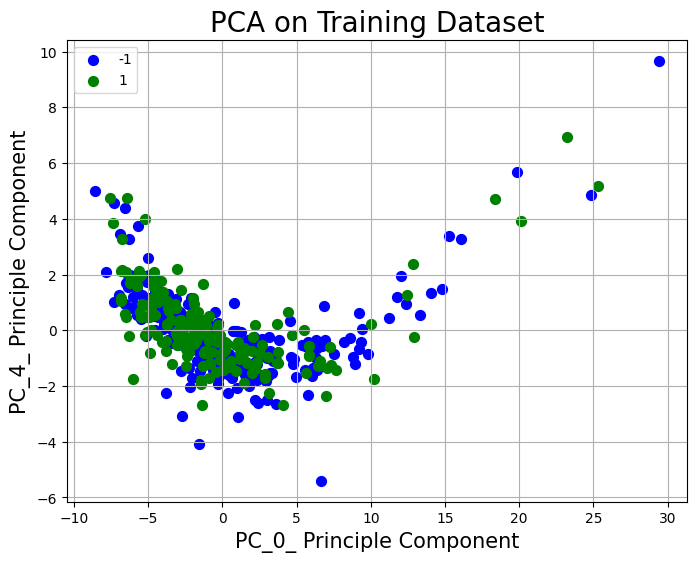

In [28]:
# Visualize Principle Components with Scatter Plot

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
col_1 = "PC_0"
col_2 = "PC_4"
ax.set_xlabel(f"{col_1}_ Principle Component", fontsize = 15)
ax.set_ylabel(f"{col_2}_ Principle Component", fontsize = 15)
ax.set_title("PCA on Training Dataset", fontsize = 20)

targets = [-1,1]
colors = ['b','g']
for target, color in zip(targets,colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep,col_1],
               df_pca.loc[indices_to_keep,col_2],
               c = color, s =50)
ax.legend(targets)
ax.grid()

### Supervised ML - Random Forest Classifier

In [58]:
classifier = RandomForestClassifier(n_estimators = i, max_depth = 2, random_state = 0)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
precisions.append(precision)
accuracies.append(accuracy)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.5634837355718783
Test Precision: 0.5265700483091788


In [57]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.3883064 , 0.6116936 ],
       [0.66366324, 0.33633676],
       [0.49832412, 0.50167588],
       ...,
       [0.52760614, 0.47239386],
       [0.51920002, 0.48079998],
       [0.54011688, 0.45988312]])

In [60]:
#Test for overfitting

train_scores, test_scores = list(), list()

values = [i for i in range(1,200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators = i, max_depth = 2, random_state = 0)
    classifier.fit(X_train,y_train)

    #Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train,y_train_pred)
    train_scores.append(accuracy_train)

    #Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test,y_test_pred)
    test_scores.append(accuracy_test)

In [63]:
train_scores>test_scores

True

In [ ]:
#Plot result

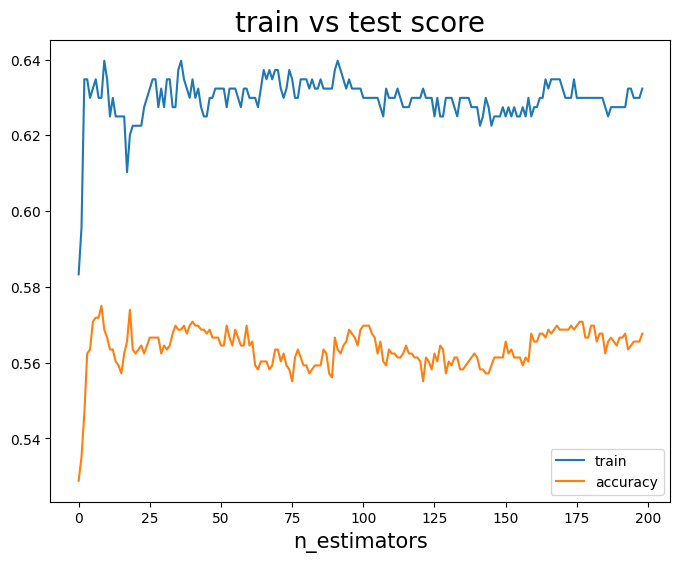

In [64]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_scores)
ax.plot(test_scores)
ax.set_xlabel("n_estimators", fontsize = 15)
ax.set_title("train vs test score", fontsize = 20)
ax.legend(['train','accuracy'])
